In [28]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import os.path as osp
import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs


In [31]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi_test.shp').to_crs(epsg='4326')
crs_proj4 = ccrs.AlbersEqualArea().proj4_init

d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
extent = [-1.1, 45.16, 17.27, 56.60]

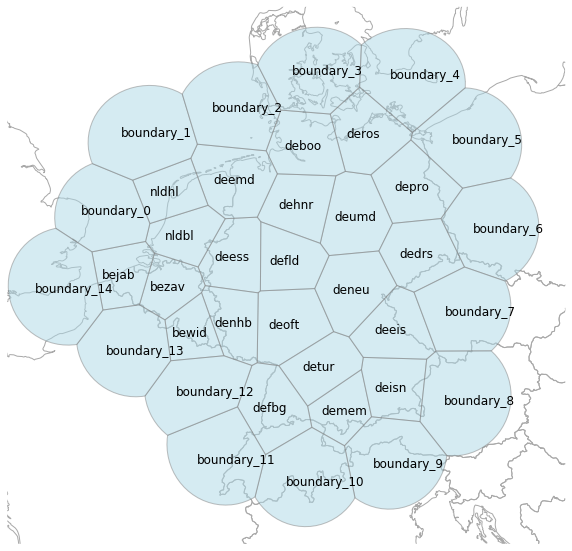

In [32]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw = {'projection' : gcrs.AlbersEqualArea()})
gplt.polyplot(countries, ax=ax, edgecolor="darkgray", extent=extent, zorder=1)
gplt.polyplot(voronoi, ax=ax, edgecolor="gray", facecolor='lightblue', alpha=0.5, extent=extent, zorder=2)

centroids = voronoi.to_crs(crs_proj4).centroid

for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, voronoi.radar):
    ax.annotate(label, xy=(x, y), xytext=(-20, -5), textcoords="offset points", fontsize=12);

In [13]:
boundary = voronoi.iloc[1].geometry.boundary
distances = np.linspace(0, boundary.length, 10)
dummy_radars = [boundary.interpolate(d) for d in distances]
dummy_radars